In [11]:
import copy
import math
import itertools
import numpy as np 
import matplotlib.pyplot as plt
from graph_based_slam import calc_rotational_matrix, calc_jacobian, cal_observation_sigma, \
                             calc_input, observation, motion_model, Edge, pi_2_pi

%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

### Introduction

In contrast to the probabilistic approaches for solving SLAM, such as EKF, UKF, particle filters, and so on, the graph technique formulates the SLAM as an optimization problem.  It is mostly used to solve the full SLAM problem in an offline fashion, i.e. optimize all the poses of the robot after the path has been traversed. However, some variants are availble that uses graph-based approaches to perform online estimation or to solve for a subset of the poses.

GraphSLAM uses the motion information as well as the observations of the environment to create least square problem that can be solved using standard optimization techniques.

### Minimal Example
The following example illustrates the main idea behind graphSLAM. 
A simple case of a 1D robot is considered that can only move in 1 direction. The robot is commanded to move forward with a control input $u_t=1$, however, the motion is not perfect and the measured odometry will deviate from the true path. At each timestep the robot can observe its environment, for this simple case as well, there is only a single landmark at coordinates $x=3$. The measured observations are the range between the robot and landmark. These measurements are also subjected to noise. No bearing information is required since this is a 1D problem.

To solve this, graphSLAM creates what is called as the system information matrix $\Omega$ also referred to as $H$ and the information vector $\xi$ also known as $b$. The entries are created based on the information of the motion and the observation.

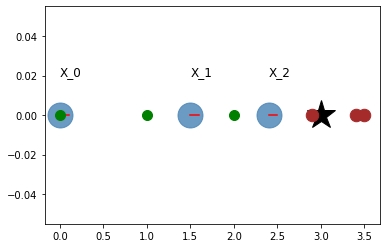

The determinant of H:  0.0
The determinant of H after anchoring constraint:  18.750000000000007
Running graphSLAM ...
Odometry values after optimzation: 
 [[-0. ]
 [ 0.9]
 [ 1.9]]


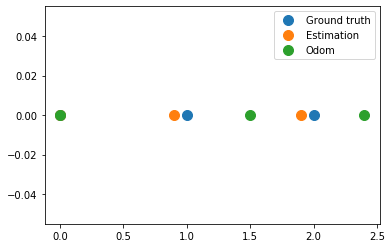

In [12]:
R = 0.2
Q = 0.2
N = 3
graphics_radius = 0.1

odom = np.empty((N,1))
obs = np.empty((N,1))
x_true = np.empty((N,1))

landmark = 3
# Simulated readings of odometry and observations
x_true[0], odom[0], obs[0] = 0.0, 0.0, 2.9
x_true[1], odom[1], obs[1] = 1.0, 1.5, 2.0
x_true[2], odom[2], obs[2] = 2.0, 2.4, 1.0

hxDR = copy.deepcopy(odom)
# Visualization
plt.plot(landmark,0, '*k', markersize=30)
for i in range(N):
    plt.plot(odom[i], 0, '.', markersize=50, alpha=0.8, color='steelblue')
    plt.plot([odom[i], odom[i] + graphics_radius],
             [0,0], 'r')
    plt.text(odom[i], 0.02, "X_{}".format(i), fontsize=12)
    plt.plot(obs[i]+odom[i],0,'.', markersize=25, color='brown')
    plt.plot(x_true[i],0,'.g', markersize=20)
plt.grid()    
plt.show()


# Defined as a function to facilitate iteration
def get_H_b(odom, obs):
    """
    Create the information matrix and information vector. This implementation is 
    based on the concept of virtual measurement i.e. the observations of the
    landmarks are converted into constraints (edges) between the nodes that
    have observed this landmark.
    """
    measure_constraints = {}
    omegas = {}
    zids = list(itertools.combinations(range(N),2))
    H = np.zeros((N,N))
    b = np.zeros((N,1))
    for (t1, t2) in zids:
        x1 = odom[t1]
        x2 = odom[t2]
        z1 = obs[t1]
        z2 = obs[t2]
        
        # Adding virtual measurement constraint
        measure_constraints[(t1,t2)] = (x2-x1-z1+z2)
        omegas[(t1,t2)] = (1 / (2*Q))
        
        # populate system's information matrix and vector
        H[t1,t1] += omegas[(t1,t2)]
        H[t2,t2] += omegas[(t1,t2)]
        H[t2,t1] -= omegas[(t1,t2)]
        H[t1,t2] -= omegas[(t1,t2)]

        b[t1] += omegas[(t1,t2)] * measure_constraints[(t1,t2)]
        b[t2] -= omegas[(t1,t2)] * measure_constraints[(t1,t2)]

    return H, b


H, b = get_H_b(odom, obs)
print("The determinant of H: ", np.linalg.det(H))
H[0,0] += 1 # np.inf ?
print("The determinant of H after anchoring constraint: ", np.linalg.det(H))

for i in range(5):
    H, b = get_H_b(odom, obs)
    H[(0,0)] += 1
    
    # Recover the posterior over the path
    dx = np.linalg.inv(H) @ b
    odom += dx
    # repeat till convergence
print("Running graphSLAM ...")    
print("Odometry values after optimzation: \n", odom)

plt.figure()
plt.plot(x_true, np.zeros(x_true.shape), '.', markersize=20, label='Ground truth')
plt.plot(odom, np.zeros(x_true.shape), '.', markersize=20, label='Estimation')
plt.plot(hxDR, np.zeros(x_true.shape), '.', markersize=20, label='Odom')
plt.legend()
plt.grid()
plt.show()

In particular, the tasks are split into 2 parts, graph construction, and graph optimization. 
### Graph Construction

Firstly the nodes are defined $\boldsymbol{x} = \boldsymbol{x}_{1:n}$  such that each node is the pose of the robot at time $t_i$
Secondly, the edges i.e. the constraints, are constructed according to the following conditions:

* robot moves from $\boldsymbol{x}_i$ to $\boldsymbol{x}_j$. This edge corresponds to the odometry measurement. Relative motion constraints (Not included in the previous minimal example).
* Measurement constraints, this can be done in two ways:
    * The information matrix is set in such a way that it includes the landmarks in the map as well. Then the constraints can be entered in a straightforward fashion between a node $\boldsymbol{x}_i$ and some landmark $m_k$
    * Through creating a virtual measurement among all the node that have observed the same landmark. More concretely, robot observes the same landmark from $\boldsymbol{x}_i$ and $\boldsymbol{x}_j$. Relative measurement constraint. The "virtual measurement" $\boldsymbol{z}_{ij}$, which is the estimated pose of $\boldsymbol{x}_j$ as seen from the node $\boldsymbol{x}_i$. The virtual measurement can then be entered in the information matrix and vector in a similar fashion to the motion constraints.

An edge is fully characterized by the values of the error (entry to information vector) and the local information matrix (entry to the system's information vector). The larger the local information matrix (lower $Q$ or $R$) the values that this edge will contribute with.

Important Notes:

* The addition to the information matrix and vector are added to the earlier values.
* In the case of 2D robot, the constraints will be non-linear, therefore, a Jacobian of the error w.r.t the states is needed when updated $H$ and $b$.
* The anchoring constraint is needed in order to avoid having a singular information matri.


### Graph Optimization

The result from this formulation yields an overdetermined system of equations.
The goal after constructing the graph is to find: $x^* = \underset{x}{\mathrm{argmin}} ~ \underset{ij} \Sigma ~ f(e_{ij}) $, where $f$ is some error function that depends on the edges between to related nodes $i$ and $j$. The derivation in the references arrive at the solution for $x^* = H^{-1}b$ 


### Planar Example:

Now we will go through an example with a more realistic case of a 2D robot with 3DoF, namely, $[x, y, \theta]^T$

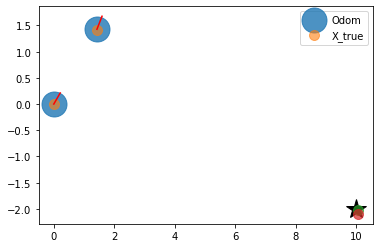

In [13]:
#  Simulation parameter
Qsim = np.diag([0.01, np.deg2rad(0.010)])**2 # error added to range and bearing
Rsim = np.diag([0.1, np.deg2rad(1.0)])**2 # error added to [v, w]

DT = 2.0  # time tick [s]
SIM_TIME = 100.0  # simulation time [s]
MAX_RANGE = 30.0  # maximum observation range
STATE_SIZE = 3  # State size [x,y,yaw]

# TODO: Why not use Qsim ? 
# Covariance parameter of Graph Based SLAM
C_SIGMA1 = 0.1
C_SIGMA2 = 0.1
C_SIGMA3 = np.deg2rad(1.0)

MAX_ITR = 20  # Maximum iteration during optimization
timesteps = 1

# consider only 2 landmarks for simplicity
# RFID positions [x, y, yaw]
RFID = np.array([[10.0, -2.0, 0.0],
#                  [15.0, 10.0, 0.0],
#                  [3.0, 15.0, 0.0],
#                  [-5.0, 20.0, 0.0],
#                  [-5.0, 5.0, 0.0]
                 ])

# State Vector [x y yaw v]'
xTrue = np.zeros((STATE_SIZE, 1))
xDR = np.zeros((STATE_SIZE, 1))  # Dead reckoning
xTrue[2] = np.deg2rad(45)
xDR[2] = np.deg2rad(45)
# history initial values
hxTrue = xTrue
hxDR = xTrue
_, z, _, _ = observation(xTrue, xDR, np.array([[0,0]]).T, RFID)
hz = [z]

for i in range(timesteps):
    u = calc_input()
    xTrue, z, xDR, ud = observation(xTrue, xDR, u, RFID)
    hxDR = np.hstack((hxDR, xDR))
    hxTrue = np.hstack((hxTrue, xTrue))
    hz.append(z)

# visualize
graphics_radius = 0.3
plt.plot(RFID[:, 0], RFID[:, 1], "*k", markersize=20)
plt.plot(hxDR[0, :], hxDR[1, :], '.', markersize=50, alpha=0.8, label='Odom')
plt.plot(hxTrue[0, :], hxTrue[1, :], '.', markersize=20, alpha=0.6, label='X_true')

for i in range(hxDR.shape[1]):
    x = hxDR[0, i]
    y = hxDR[1, i]
    yaw = hxDR[2, i]
    plt.plot([x, x + graphics_radius * np.cos(yaw)],
             [y, y + graphics_radius * np.sin(yaw)], 'r')
    d = hz[i][:, 0]
    angle = hz[i][:, 1]
    plt.plot([x + d * np.cos(angle + yaw)], [y + d * np.sin(angle + yaw)], '.',
             markersize=20, alpha=0.7)
    plt.legend()
plt.grid()    
plt.show()

In [14]:
# Copy the data to have a consistent naming with the .py file
zlist = copy.deepcopy(hz)
x_opt = copy.deepcopy(hxDR)
xlist = copy.deepcopy(hxDR)
number_of_nodes = x_opt.shape[1]
n = number_of_nodes * STATE_SIZE

After the data has been saved, the graph will be constructed by looking at each pair for nodes. The virtual measurement is only created if two nodes have observed the same landmark at different points in time. The next cells are a walk through for a single iteration of graph construction -> optimization -> estimate update. 

In [15]:
# get all the possible combination of the different node
zids = list(itertools.combinations(range(len(zlist)), 2))
print("Node combinations: \n", zids)

for i in range(xlist.shape[1]):
    print("Node {} observed landmark with ID {}".format(i, zlist[i][0, 3]))

Node combinations: 
 [(0, 1)]
Node 0 observed landmark with ID 0.0
Node 1 observed landmark with ID 0.0


In the following code snippet the error based on the virtual measurement between node 0 and 1 will be created.
The equations for the error is as follows: 
$e_{ij}^x = x_j + d_j cos(\psi_j + \theta_j) - x_i - d_i cos(\psi_i + \theta_i) $

$e_{ij}^y = y_j + d_j sin(\psi_j + \theta_j) - y_i - d_i sin(\psi_i + \theta_i) $

$e_{ij}^x = \psi_j + \theta_j - \psi_i - \theta_i $

Where $[x_i, y_i, \psi_i]$ is the pose for node $i$ and similarly for node $j$, $d$ is the measured distance at nodes $i$ and $j$, and $\theta$ is the measured bearing to the landmark. The difference is visualized with the figure in the next cell.

In case of perfect motion and perfect measurement the error shall be zero since $ x_j + d_j cos(\psi_j + \theta_j)$ should equal $x_i + d_i cos(\psi_i + \theta_i)$

0.0 1.427649841628278 -2.0126109674819155 -3.524048014922737
For nodes (0, 1)
Added edge with errors: 
 [[-0.02 ]
 [-0.084]
 [ 0.   ]]


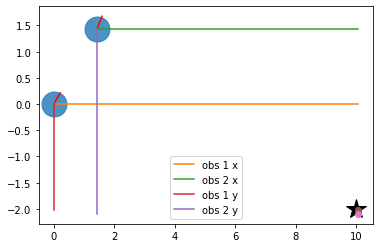

In [16]:
# Initialize edges list
edges = []

# Go through all the different combinations
for (t1, t2) in zids:
    x1, y1, yaw1 = xlist[0, t1], xlist[1, t1], xlist[2, t1]
    x2, y2, yaw2 = xlist[0, t2], xlist[1, t2], xlist[2, t2]
    
    # All nodes have valid observation with ID=0, therefore, no data association condition
    iz1 = 0
    iz2 = 0
    
    d1 = zlist[t1][iz1, 0]
    angle1, phi1 = zlist[t1][iz1, 1], zlist[t1][iz1, 2]
    d2 = zlist[t2][iz2, 0]
    angle2, phi2 = zlist[t2][iz2, 1], zlist[t2][iz2, 2]
    
    # find angle between observation and horizontal 
    tangle1 = pi_2_pi(yaw1 + angle1)
    tangle2 = pi_2_pi(yaw2 + angle2)
    
    # project the observations 
    tmp1 = d1 * math.cos(tangle1)
    tmp2 = d2 * math.cos(tangle2)
    tmp3 = d1 * math.sin(tangle1)
    tmp4 = d2 * math.sin(tangle2)
    
    edge = Edge()
    print(y1,y2, tmp3, tmp4)
    # calculate the error of the virtual measurement
    # node 1 as seen from node 2 throught the observations 1,2
    edge.e[0, 0] = x2 - x1 - tmp1 + tmp2
    edge.e[1, 0] = y2 - y1 - tmp3 + tmp4
    edge.e[2, 0] = pi_2_pi(yaw2 - yaw1 - tangle1 + tangle2)

    edge.d1, edge.d2 = d1, d2
    edge.yaw1, edge.yaw2 = yaw1, yaw2
    edge.angle1, edge.angle2 = angle1, angle2
    edge.id1, edge.id2 = t1, t2
    
    edges.append(edge)
    
    print("For nodes",(t1,t2))
    print("Added edge with errors: \n", edge.e)
    
    # Visualize measurement projections
    plt.plot(RFID[0, 0], RFID[0, 1], "*k", markersize=20)
    plt.plot([x1,x2],[y1,y2], '.', markersize=50, alpha=0.8)
    plt.plot([x1, x1 + graphics_radius * np.cos(yaw1)],
             [y1, y1 + graphics_radius * np.sin(yaw1)], 'r')
    plt.plot([x2, x2 + graphics_radius * np.cos(yaw2)],
             [y2, y2 + graphics_radius * np.sin(yaw2)], 'r')
    
    plt.plot([x1,x1+tmp1], [y1,y1], label="obs 1 x")
    plt.plot([x2,x2+tmp2], [y2,y2], label="obs 2 x")
    plt.plot([x1,x1], [y1,y1+tmp3], label="obs 1 y")
    plt.plot([x2,x2], [y2,y2+tmp4], label="obs 2 y")
    plt.plot(x1+tmp1, y1+tmp3, 'o')
    plt.plot(x2+tmp2, y2+tmp4, 'o')
plt.legend()
plt.grid()
plt.show()

Since the constraints equations derived before are non-linear, linearization is needed before we can insert them into the information matrix and information vector. Two jacobians 

$A = \frac{\partial e_{ij}}{\partial \boldsymbol{x}_i}$ as $\boldsymbol{x}_i$ holds the three variabls x, y, and theta.
Similarly, 
$B = \frac{\partial e_{ij}}{\partial \boldsymbol{x}_j}$ 

The determinant of H:  0.0
The determinant of H after origin constraint:  716.1972439134893


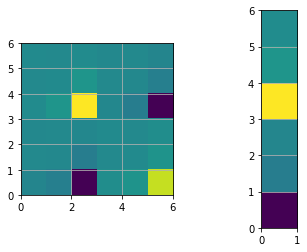

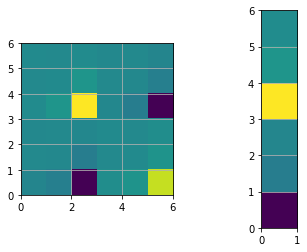

In [17]:
# Initialize the system information matrix and information vector
H = np.zeros((n, n))
b = np.zeros((n, 1))
x_opt = copy.deepcopy(hxDR)

for edge in edges:
    id1 = edge.id1 * STATE_SIZE
    id2 = edge.id2 * STATE_SIZE
    
    t1 = edge.yaw1 + edge.angle1
    A = np.array([[-1.0, 0, edge.d1 * math.sin(t1)],
                  [0, -1.0, -edge.d1 * math.cos(t1)],
                  [0, 0, -1.0]])

    t2 = edge.yaw2 + edge.angle2
    B = np.array([[1.0, 0, -edge.d2 * math.sin(t2)],
                  [0, 1.0, edge.d2 * math.cos(t2)],
                  [0, 0, 1.0]])
    
    # TODO: use Qsim instead of sigma
    sigma = np.diag([C_SIGMA1, C_SIGMA2, C_SIGMA3])
    Rt1 = calc_rotational_matrix(tangle1)
    Rt2 = calc_rotational_matrix(tangle2)
    edge.omega = np.linalg.inv(Rt1 @ sigma @ Rt1.T + Rt2 @ sigma @ Rt2.T)

    # Fill in entries in H and b
    H[id1:id1 + STATE_SIZE, id1:id1 + STATE_SIZE] += A.T @ edge.omega @ A
    H[id1:id1 + STATE_SIZE, id2:id2 + STATE_SIZE] += A.T @ edge.omega @ B
    H[id2:id2 + STATE_SIZE, id1:id1 + STATE_SIZE] += B.T @ edge.omega @ A
    H[id2:id2 + STATE_SIZE, id2:id2 + STATE_SIZE] += B.T @ edge.omega @ B

    b[id1:id1 + STATE_SIZE] += (A.T @ edge.omega @ edge.e)
    b[id2:id2 + STATE_SIZE] += (B.T @ edge.omega @ edge.e)
   

print("The determinant of H: ", np.linalg.det(H))
plt.figure()
plt.subplot(1,2,1)
plt.imshow(H, extent=[0, n, 0, n])
plt.subplot(1,2,2)
plt.imshow(b, extent=[0, 1, 0, n])
plt.show()    

# Fix the origin, multiply by large number gives same results but better visualization
H[0:STATE_SIZE, 0:STATE_SIZE] += np.identity(STATE_SIZE)
print("The determinant of H after origin constraint: ", np.linalg.det(H))    
plt.figure()
plt.subplot(1,2,1)
plt.imshow(H, extent=[0, n, 0, n])
plt.subplot(1,2,2)
plt.imshow(b, extent=[0, 1, 0, n])
plt.show()

In [18]:
# Find the solution (first iteration)
dx = - np.linalg.inv(H) @ b
for i in range(number_of_nodes):
    x_opt[0:3, i] += dx[i * 3:i * 3 + 3, 0]
print("dx: \n",dx)
print("ground truth: \n ",hxTrue)
print("Odom: \n", hxDR)
print("SLAM: \n", x_opt)

# performance will improve with more iterations, nodes and landmarks.
print("\ngraphSLAM localization error: ", np.sum((x_opt - hxTrue) ** 2))
print("Odom localization error: ", np.sum((hxDR - hxTrue) ** 2))

dx: 
 [[-0.   ]
 [-0.   ]
 [ 0.   ]
 [ 0.02 ]
 [ 0.084]
 [-0.   ]]
ground truth: 
  [[0.    1.414]
 [0.    1.414]
 [0.785 0.985]]
Odom: 
 [[0.    1.428]
 [0.    1.428]
 [0.785 0.976]]
SLAM: 
 [[-0.     1.448]
 [-0.     1.512]
 [ 0.785  0.976]]

graphSLAM localization error:  0.010729072751057656
Odom localization error:  0.0004460978857535104


### The references:


* http://robots.stanford.edu/papers/thrun.graphslam.pdf

* http://ais.informatik.uni-freiburg.de/teaching/ss13/robotics/slides/16-graph-slam.pdf

* http://www2.informatik.uni-freiburg.de/~stachnis/pdf/grisetti10titsmag.pdf

N.B.
An additional step is required that uses the estimated path to update the belief regarding the map.